<a href="https://colab.research.google.com/github/Anth-us/Benfords-Law-article/blob/main/Benfords_Law_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from tqdm import tqdm
import matplotlib as mpl
import matplotlib.patheffects as path_effects

# Set the color for all text to #333
mpl.rcParams['text.color'] = '#333'
mpl.rcParams['xtick.labelsize']=20

def fetch_and_analyze_data_file(data_info):
    response = requests.get(data_info['csv_url'], stream=True)
    total_size_in_bytes = int(response.headers.get('content-length', 0))
    block_size = 1024  # 1 Kilobyte

    # Updated progress bar using tqdm
    with open(data_info['filename'], 'wb') as file, tqdm(
            desc=data_info['filename'],
            total=total_size_in_bytes,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as progress_bar:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)

    # Analyze the data length
    analyze_data_length(data_info['filename'], data_info['column_to_analyze'])

def analyze_data_length(file_path, column_name):
    df = pd.read_csv(file_path, low_memory=False)
    print(f"Total rows in the dataset: {len(df)}")

    # Cleaning the data
    df[column_name] = df[column_name].astype(str).str.replace('[^\d.]', '', regex=True)
    df[column_name] = df[column_name].str.split('.').str[0]  # Keep only the part before the decimal
    df = df[df[column_name] != '0']  # Ignore '0' values

    # Calculating number length breakdown
    df['length'] = df[column_name].str.len()
    length_breakdown = df['length'].value_counts().sort_index()

    print("Number length breakdown:")
    for length, count in length_breakdown.items():
        print(f"{length}: {count}")

def read_dataframe_from_csv(data_info):
    file_path = data_info['filename']
    if not os.path.exists(file_path):  # Check if the file does not exist
        print("Fetching data file...")
        fetch_and_analyze_data_file(data_info)  # Fetch the file if it's not already downloaded
        print("Data file fetched.")

    try:
        df = pd.read_csv(file_path, low_memory=False)
        return df
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

def compute_first_digit_breakdown(df, column_name):
    try:
        first_digits = []
        for index, value in df[column_name].dropna().iteritems():
            cleaned_value = str(value).strip().replace(',', '').replace('$', '').replace(' ', '')
            first_digit = cleaned_value[0] if cleaned_value and cleaned_value[0].isdigit() and cleaned_value[0] != '0' else None
            if first_digit:
                first_digits.append(int(first_digit))
        breakdown = pd.Series(first_digits).value_counts().sort_index()
        return breakdown
    except Exception as e:
        print(f"An error occurred during processing: {e}")
        return None

# Define the updated plot function with Benford's overlay correctly scaled
def plot_first_digit_distribution(breakdown_data, data_info, benfords_overlay=False):
    aspect_ratio = data_info.get('aspect_ratio', '16:9')
    if aspect_ratio == 'square':
        figsize = (8, 8)
    elif aspect_ratio == '16:9':
        figsize = (16, 9)
    else:
        figsize = (10, 6)  # Default size

    plt.figure(figsize=figsize)
    plt.suptitle(data_info['title'], fontsize=24)
    plt.title(data_info['subtitle'], fontsize=14)

    # Plot the actual data distribution as bars
    ax = breakdown_data.plot(kind='bar', color=(0.815, 0.2, 0.51), align='center')

    # Set the x-ticks to match the first digits (1-9)
    ax.set_xticks(range(len(breakdown_data)))
    ax.set_xticklabels(range(1, len(breakdown_data) + 1), rotation=0)

    if benfords_overlay:
        # Calculate Benford's distribution for each digit
        benfords_dist = [np.log10(1 + 1/digit) for digit in range(1, 10)]
        # Calculate the predicted count for Benford's distribution
        total_count = breakdown_data.sum()
        benfords_predicted = [count * total_count for count in benfords_dist]

        # Overlay Benford's distribution as a line plot using zero-based indexing for x-values
        plt.plot(range(len(breakdown_data)), benfords_predicted, color=(0.815, 0.2, 0.51), linewidth=3, linestyle='-',
                 path_effects=[path_effects.withStroke(linewidth=6, foreground='white')])
        plt.scatter(range(len(breakdown_data)), benfords_predicted, color=(0.815, 0.2, 0.51), s=9**2, zorder=3,
                    path_effects=[path_effects.withStroke(linewidth=6, foreground='white')])

    plt.xlabel('Lead Digit', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.grid(axis='y')

    # Save the plot as an image file
    image_filename = data_info['filename'].replace('.csv', '.png')
    plt.savefig(image_filename)
    plt.show()

    print(f"Chart saved as {image_filename}")

def render_histogram_chart(data_info, benfords_overlay=True):
    df = read_dataframe_from_csv(data_info)
    if df is None or data_info['column_to_analyze'] not in df.columns:
        return

    breakdown_data = compute_first_digit_breakdown(df, data_info['column_to_analyze'])
    if breakdown_data is not None:
        plot_first_digit_distribution(breakdown_data, data_info, benfords_overlay)

In [ ]:
connecticut_real_estate_sales = {
    'title': 'Real Estate Sale Prices',
    'subtitle': 'All sales with a sales price of $2,000 or greater that occur between October 1 and September 30 of each year, 2001-2020',
    'filename': 'connecticut-real-estate-sales.csv',
    'csv_url': 'https://data.ct.gov/api/views/5mzw-sjtu/rows.csv?accessType=DOWNLOAD',
    'column_to_analyze': 'Sale Amount',
    'aspect_ratio': '16:9',
    'source': 'https://catalog.data.gov/dataset/?q=&sort=views_recent+desc'
}

fetch_and_analyze_data_file(connecticut_real_estate_sales)

connecticut-real-estate-sales.csv: 105MiB [01:14, 1.48MiB/s]


Total rows in the dataset: 997213
Number length breakdown:
1: 53
2: 8
3: 60
4: 8241
5: 137195
6: 801611
7: 46666
8: 1520
9: 48
10: 1


<ipython-input-24-5a7fbb7aa696>:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df[column_name].dropna().iteritems():


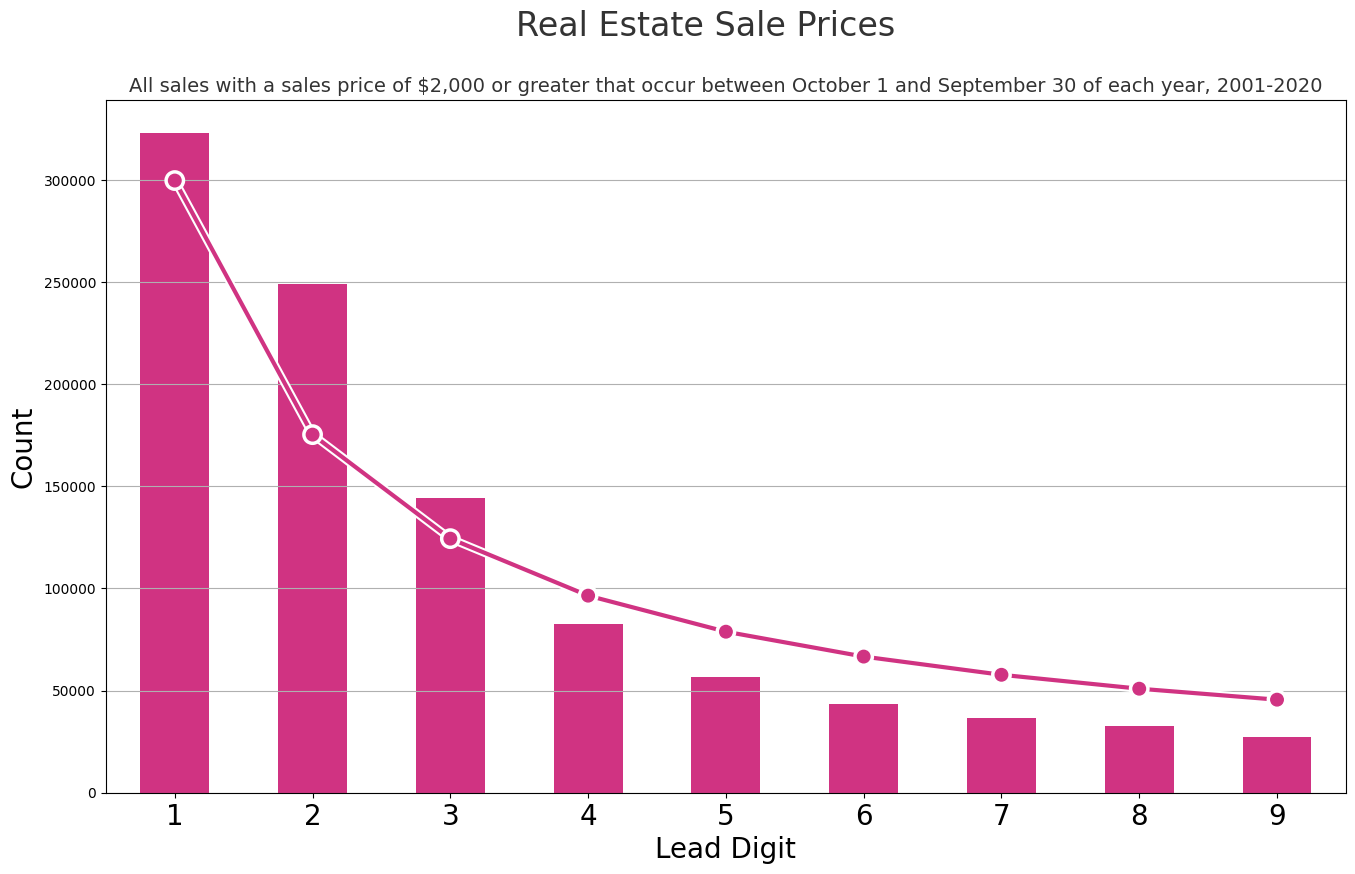

Chart saved as connecticut-real-estate-sales.png


In [ ]:
render_histogram_chart(connecticut_real_estate_sales)

In [ ]:
new_york_baby_names = {
    'title': 'Baby Name Registration Counts',
    'subtitle': 'Counts of frequency of baby names collected through civil birth registrations.',
    'filename': 'new-york-baby-names.csv',
    'csv_url': 'https://data.cityofnewyork.us/api/views/25th-nujf/rows.csv?accessType=DOWNLOAD',
    'column_to_analyze': 'Count',
    'aspect_ratio': '16:9',
    'source': 'https://catalog.data.gov/dataset/popular-baby-names'
}

fetch_and_analyze_data_file(new_york_baby_names)

new-york-baby-names.csv: 2.22MiB [00:00, 2.98MiB/s]


Total rows in the dataset: 57582
Number length breakdown:
2: 54031
3: 3551


<ipython-input-24-5a7fbb7aa696>:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df[column_name].dropna().iteritems():


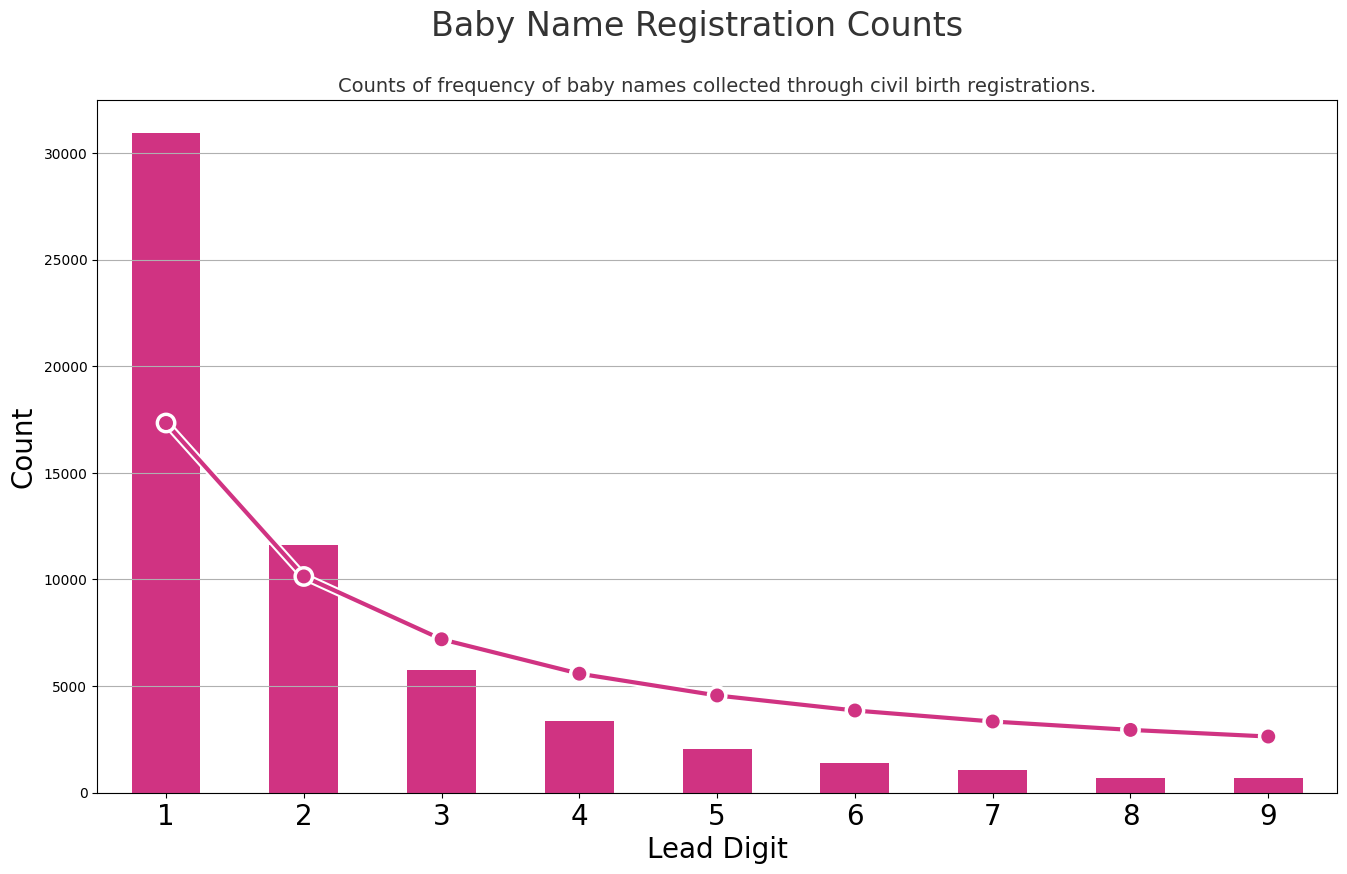

Chart saved as new-york-baby-names.png


In [ ]:
render_histogram_chart(new_york_baby_names)

In [ ]:
connecticut_school_attendance = {
    'title': 'Connecticut School Attendance',
    'subtitle': 'Attendance counts by Student Group and District, 2021-2022',
    'filename': 'connecticut-school-attendance.csv',
    'csv_url': 'https://data.ct.gov/api/views/t4hx-jd4c/rows.csv?accessType=DOWNLOAD',
    'column_to_analyze': '2020-2021 student count',
    'aspect_ratio': '16:9',
    'source': 'https://catalog.data.gov/dataset/school-attendance-by-student-group-and-district-2021-2022'
}

fetch_and_analyze_data_file(connecticut_school_attendance)

connecticut-school-attendance.csv: 249kiB [00:00, 15.5MiB/s]

Total rows in the dataset: 2019
Number length breakdown:
0: 56
2: 406
3: 1033
4: 491
5: 26
6: 7


<ipython-input-24-5a7fbb7aa696>:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df[column_name].dropna().iteritems():


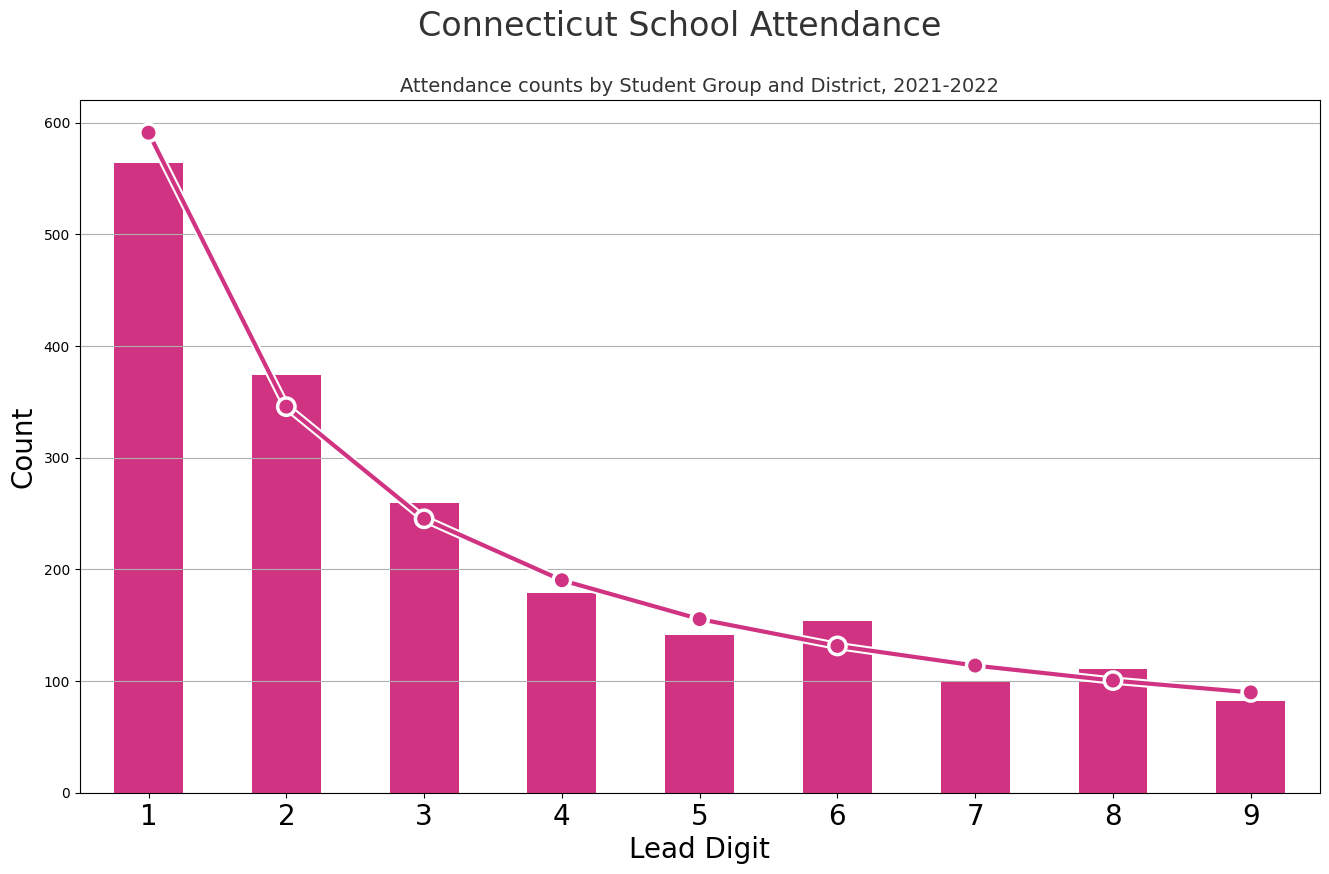

Chart saved as connecticut-school-attendance.png


In [ ]:
render_histogram_chart(connecticut_school_attendance)

In [ ]:
border_crossing_counts = {
    'title': 'Border Crossing Counts',
    'subtitle': 'Counts of different kinds of border crossings by port of entry.',
    'filename': 'border-crossing-counts.csv',
    'csv_url': 'https://data.transportation.gov/api/views/keg4-3bc2/rows.csv?accessType=DOWNLOAD',
    'column_to_analyze': 'Value',
    'aspect_ratio': '16:9',
    'source': 'https://catalog.data.gov/dataset/border-crossing-entry-data-683ae'
}

fetch_and_analyze_data_file(border_crossing_counts)

border-crossing-counts.csv: 42.7MiB [00:11, 4.02MiB/s]


Total rows in the dataset: 386549
Number length breakdown:
1: 16311
2: 47085
3: 70310
4: 67639
5: 42562
6: 18240
7: 2002


<ipython-input-24-5a7fbb7aa696>:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df[column_name].dropna().iteritems():


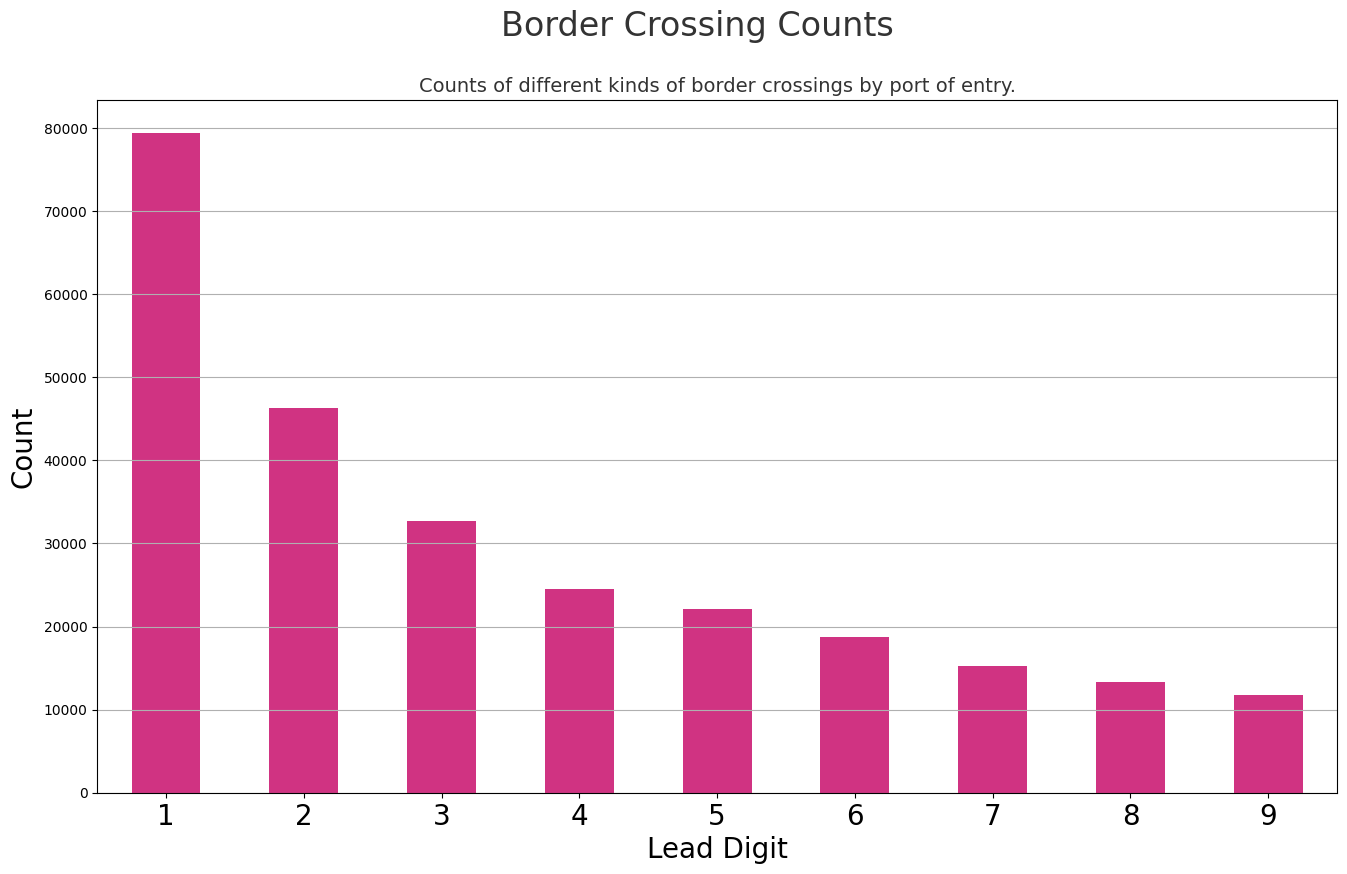

Chart saved as border-crossing-counts.png


In [ ]:
render_histogram_chart(border_crossing_counts, False)

In [ ]:
#
nyc_covid19_cases = {
    'title': 'New York COVID-19 Cases',
    'subtitle': 'Daily count of NYC residents who tested positive for SARS-CoV-2.',
    'filename': 'nyc_covid19_cases.csv',
    'csv_url': 'https://data.cityofnewyork.us/api/views/rc75-m7u3/rows.csv?accessType=DOWNLOAD',
    'column_to_analyze': 'CASE_COUNT',
    'aspect_ratio': '16:9',
    'source': 'https://catalog.data.gov/dataset/covid-19-daily-counts-of-cases-hospitalizations-and-deaths'
}

fetch_and_analyze_data_file(nyc_covid19_cases)

nyc_covid19_cases.csv: 235kiB [00:00, 2.31MiB/s]

Total rows in the dataset: 1158
Number length breakdown:
1: 6
2: 5
3: 458
4: 656
5: 31


<ipython-input-24-5a7fbb7aa696>:70: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df[column_name].dropna().iteritems():


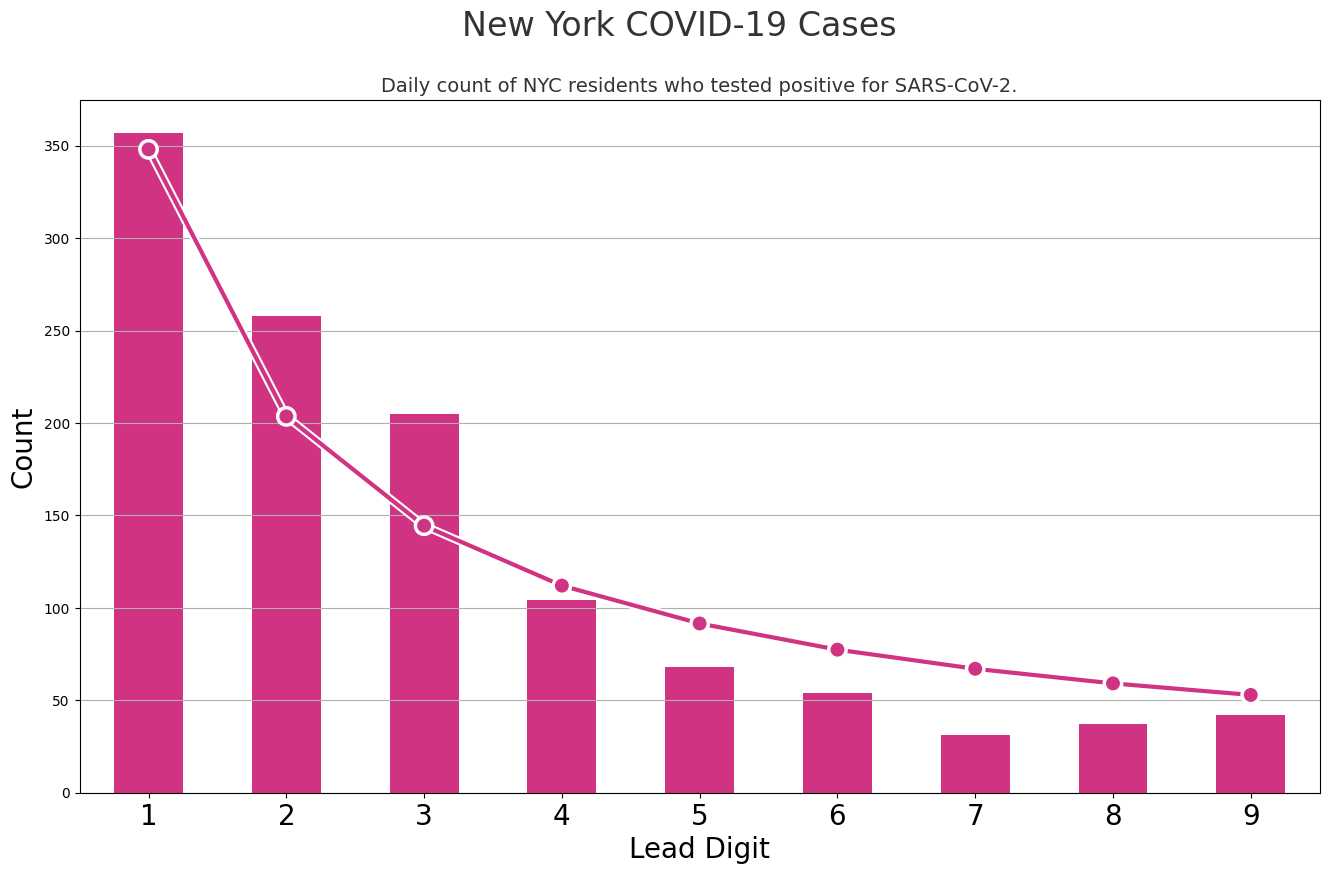

Chart saved as nyc_covid19_cases.png


In [ ]:
render_histogram_chart(nyc_covid19_cases)